In [2]:
!pip install -q -q -q geopandas
!pip install -q -q -q btbpy
!pip install -q -q -q descartes
!pip install -q -q -q mapclassify

In [18]:
import numpy as np
import pandas as pd

import geopandas as gpd
import btbpy
from shapely.geometry import Polygon
from pyproj import Transformer, transform
import matplotlib.pyplot as plt

import os

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KDTree
from sklearn.neighbors import RadiusNeighborsRegressor

In [9]:
df = pd.read_csv('Filosofi2015_french_grid.zip', compression='zip')
df.head(3)

,x,y,Ind,Men,Men_pauv
0,3763200,2893400,2818.5,990.0,280.0
1,3762200,2890000,1543.5,926.0,128.0
2,3762400,2893400,1338.0,508.0,131.0


### Analyses multifractales classiques sur 3 zones

In [10]:
side=48000

In [11]:
x,y = 3908800, 2887400
aire_openfield = df[(df.x >= x-side/2 ) & (df.x <= (x + side/2)) & (df.y>= y- side/2) & (df.y<= (y+side/2))].copy()
aire_openfield['P'] = aire_openfield.Ind / aire_openfield.Ind.sum() * 100000

x,y = 3524600, 2917600#vire
aire_bocage = df[(df.x >= x-side/2 ) & (df.x <= (x + side/2)) & (df.y>= y- side/2) & (df.y<= (y+side/2))].copy()
aire_bocage['P'] = aire_bocage.Ind / aire_bocage.Ind.sum() * 100000

x,y = 3761000, 2889800#paris
aire_paris = df[(df.x >= x-side/2 ) & (df.x <= (x + side/2)) & (df.y>= y- side/2) & (df.y<= (y+side/2))].copy()
aire_paris['P'] = aire_paris.Ind / aire_paris.Ind.sum() * 100000

print('population :', aire_openfield.Ind.sum(), aire_bocage.Ind.sum(), aire_paris.Ind.sum())
print('carreaux :', aire_openfield.shape[0], aire_bocage.shape[0], aire_paris.shape[0])

population : 117988.5 138186.0 9592991.0
carreaux : 3253 16165 30717


In [12]:
saire_paris = btbpy.dfToGrid(aire_paris, '2154', 200, verbose=False)
saire_bocage = btbpy.dfToGrid(aire_bocage, '2154', 200, verbose=False)
saire_openfield = btbpy.dfToGrid(aire_openfield, '2154', 200, verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


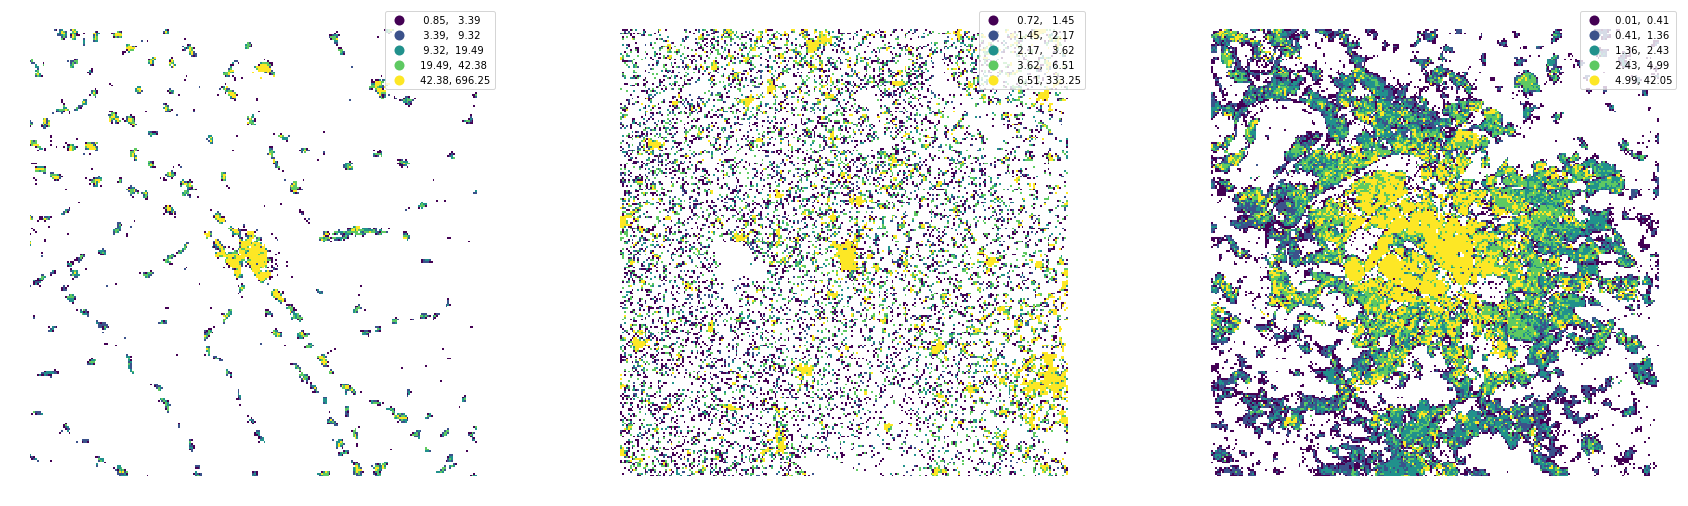

In [19]:
fig, axs = plt.subplots(ncols = 3, figsize=(30,10))
saire_openfield.plot('P',figsize=(10,10), ax = axs[0], scheme='Quantiles', legend=True)
axs[0].set_axis_off()
saire_bocage.plot('P',figsize=(10,10), ax = axs[1], scheme='Quantiles', legend=True)
axs[1].set_axis_off()
saire_paris.plot('P',figsize=(10,10), ax = axs[2], scheme='Quantiles', legend=True)
axs[2].set_axis_off()

In [20]:
def alphaq(P, Pq, q):
    return(np.sum(np.log2(P) * Pq))

def falphaq(Pq, q):
    return(np.sum(np.log2(Pq) * Pq))

def entropy(P, q):
    if q==1:
        return(np.sum(np.log2(P) * P))
    else:
        return(-np.log2(np.sum(P**q))/(1-q))

def alphaFalpha(M, size, qs):
    P = M.copy()
    P.Ind = P.Ind / P.Ind.sum()
    
    alpha = np.zeros((size.size, qs.size))
    falpha = np.zeros((size.size, qs.size))
    Dq = np.zeros((size.size, qs.size))
    for i,s in enumerate(size):
        P.x = np.floor(P.x/s) * s
        P.y = np.floor(P.y/s) * s
        P = P.groupby(['x', 'y'], as_index=False)['Ind'].sum()
        for j,q in enumerate(qs):
            Pq = P.Ind**q / np.sum(P.Ind**q) 
            alpha[i,j] = alphaq(P.Ind, Pq, q)
            falpha[i,j] = falphaq(Pq, q)
            Dq[i,j] = entropy(P.Ind,q)
    Dq = pd.DataFrame(Dq)
    Dq.columns = qs
    alpha = pd.DataFrame(alpha)
    alpha.columns = qs
    falpha = pd.DataFrame(falpha)
    falpha.columns = qs
    return(alpha, falpha, Dq)

In [15]:
entropy(P, q)

NameError: name 'P' is not defined

In [21]:
size = np.array([800, 1600, 3200, 6400])
qs = np.arange(0,2.1,0.1)
Beta = (np.log2(size) - np.log2(size).mean())/ np.log2(size).var() /4

In [22]:
alpha, falpha, Dq = alphaFalpha(aire_bocage, size, qs)
spectre_bocage = pd.DataFrame({'alpha': alpha.mul(Beta, axis=0).sum(0),
                               'falpha' : falpha.mul(Beta, axis=0).sum(0)})
Dq_bocage = pd.DataFrame({'q' : qs, 'Dq' : Dq.mul(Beta, axis=0).sum(0)})

alpha, falpha, Dq = alphaFalpha(aire_openfield, size, qs)
spectre_openfield = pd.DataFrame({'alpha': alpha.mul(Beta, axis=0).sum(0),
                               'falpha' : falpha.mul(Beta, axis=0).sum(0)})
Dq_openfield = pd.DataFrame({'q' : qs, 'Dq' : Dq.mul(Beta, axis=0).sum(0)})

alpha, falpha, Dq = alphaFalpha(aire_paris, size, qs)
spectre_paris = pd.DataFrame({'alpha': alpha.mul(Beta, axis=0).sum(0),
                               'falpha' : falpha.mul(Beta, axis=0).sum(0)})
Dq_paris = pd.DataFrame({'q' : qs, 'Dq' : Dq.mul(Beta, axis=0).sum(0)})

Text(0.5, 1.0, 'Dimensions généralisées')

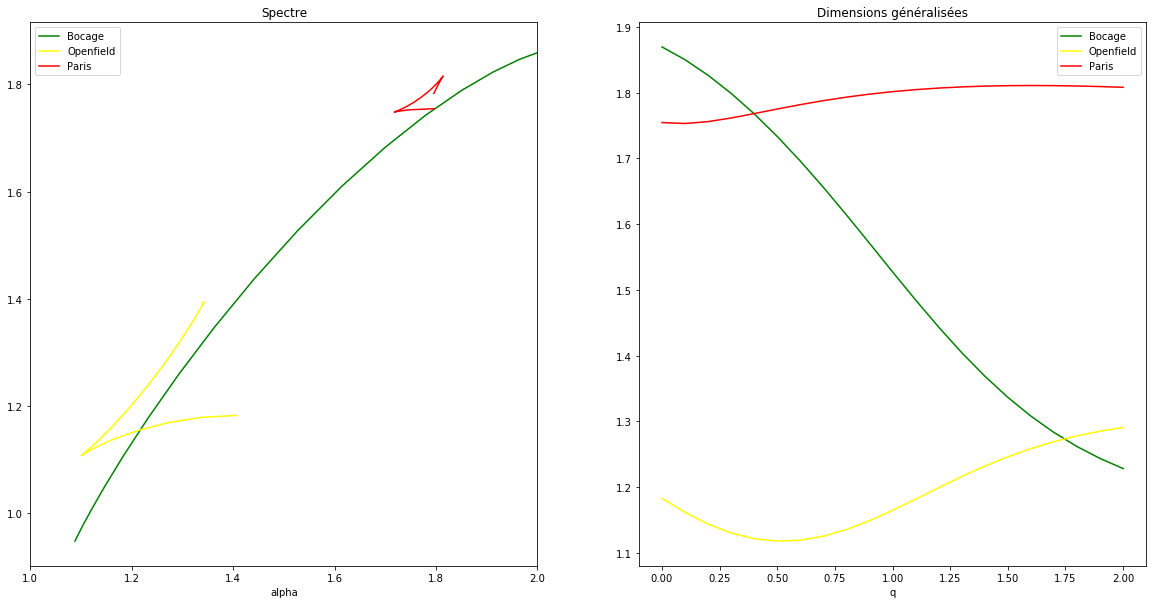

In [23]:
fig, ax = plt.subplots(ncols = 2, figsize=(20,10))

spectre_bocage.plot.line('alpha', 'falpha', color='green', label='Bocage', ax=ax[0])
spectre_openfield.plot.line('alpha', 'falpha', ax=ax[0], color='yellow', label='Openfield')
spectre_paris.plot.line('alpha', 'falpha', ax=ax[0], color='red', label='Paris')
ax[0].set_xlim((0,2.5))
ax[0].set_xlim((1,2))
ax[0].set_title('Spectre')

Dq_bocage.plot.line('q', 'Dq', color='green', label='Bocage', ax=ax[1])
Dq_openfield.plot.line('q', 'Dq', ax=ax[1], color='yellow', label='Openfield')
Dq_paris.plot.line('q', 'Dq', ax=ax[1], color='red', label='Paris')
ax[1].set_title('Dimensions généralisées')

In [134]:
def neighbors_near_point(df, weight, list_of_radius):
    neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
    for i, r in enumerate(list_of_radius):
        tree = KDTree(df[['x', 'y']]) 
        neigh = RadiusNeighborsRegressor(radius=r)
        neigh.fit(df[['x', 'y']],  df[weight])
        neighbors[:,i] = tree.query_radius(df[['x', 'y']], r= r, count_only=True) * neigh.predict(df[['x', 'y']])
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    return(pd.concat([df[['x', 'y', weight]].reset_index(), result], axis=1))
    

def entropyq(P, q, p):
    if q==1:
        return(np.sum(p*np.log2(P)))
    else:
        return(-np.log2(np.sum(p * P**(q-1)))/(1-q))

def sandbox(M, size, qs):
    df = neighbors_near_point(M, 'Ind', size)
    Dq = np.zeros((size.size, qs.size))
    p = M.Ind.values / M.Ind.sum()  
    for i,s in enumerate(size):
        for j,q in enumerate(qs):
            Dq[i,j] = entropyq(df[str(s)].values,q, p)
    Dq = pd.DataFrame(Dq)
    Dq.columns = qs
    return(Dq)

In [135]:
list_of_radius = np.array([400, 800, 1600, 3200])
qs = np.arange(0,2.1,0.1)
Beta_radius = (np.log2(list_of_radius) - np.log2(list_of_radius).mean())/ np.log2(list_of_radius).var() /4

In [136]:
Dqsr_bocage = sandbox(aire_bocage, list_of_radius, qs)
Dqs_bocage = pd.DataFrame({'q': qs, 'Dq':Dqsr_bocage.mul(Beta_radius, axis=0).sum(0)})

Dqsr_openfield = sandbox(aire_openfield, list_of_radius, qs)
Dqs_openfield = pd.DataFrame({'q': qs, 'Dq':Dqsr_openfield.mul(Beta_radius, axis=0).sum(0)})

Dqsr_paris = sandbox(aire_paris, list_of_radius, qs)
Dqs_paris = pd.DataFrame({'q': qs, 'Dq':Dqsr_paris.mul(Beta_radius, axis=0).sum(0)})

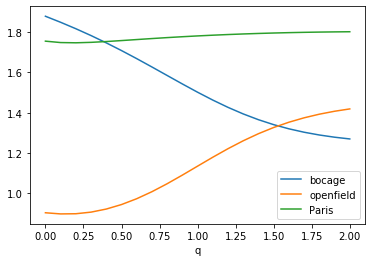

In [138]:
ax = Dqs_bocage.plot.line('q', 'Dq', label='bocage')
Dqs_openfield.plot.line('q', 'Dq', ax=ax, label='openfield')
Dqs_paris.plot.line('q', 'Dq', ax=ax, label='Paris')

In [31]:
Dqs_paris

,q,Dq
0.0,0.0,2.405071
0.1,0.1,2.285247
0.2,0.2,2.172608
0.3,0.3,2.076846
0.4,0.4,2.003047
0.5,0.5,1.950462
0.6,0.6,1.914723
0.7,0.7,1.890765
0.8,0.8,1.874445
0.9,0.9,1.862896


In [65]:
test['400_log'] = np.log(test['400']) / test['400']
test['800_log'] = np.log(test['800']) / test['800']
test['1600_log'] = np.log(test['1600']) / test['1600']
test['3200_log'] = np.log(test['3200']) / test['3200']

test['400_log2'] = test['400_log']**2
test['800_log2'] = test['800_log']**2
test['1600_log2'] = test['1600_log']**2
test['3200_log2'] = test['3200_log']**2
test['cells'] = 1

In [189]:
chem_data_dir = os.path.join(os.path.dirname(btbpy.__file__),'data')
chem_data_grid = os.path.join(chem_data_dir, 'fr_metro_grid1km.csv')
fr_1km = pd.read_csv(chem_data_grid)

In [46]:
fr_2km = fr_1km.copy()
fr_2km['x'] = np.floor(fr_2km['x'] / 2000) * 2000 + 1000
fr_2km['y'] = np.floor(fr_2km['y'] / 2000) * 2000 + 1000
fr_2km['ind'] = 1
fr_2km = fr_2km.groupby(['x', 'y'], as_index=False).count()
fr_2km = fr_2km[['x', 'y']]

In [67]:
scale_function = btbpy.kernelSmoothing(test, '2154', 2000, 20000, fr_2km, verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [68]:
log = [ r+'_log' for r in list_of_radius.astype(str)]
scale_function['c1'] = scale_function[log].apply(lambda x :LinearRegression().fit(np.log(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] ,   axis=1 )

In [71]:
scale_function['c1'] = - scale_function['c1'] 

(42800.0, 1301200.0, 5996900.0, 7165100.0)

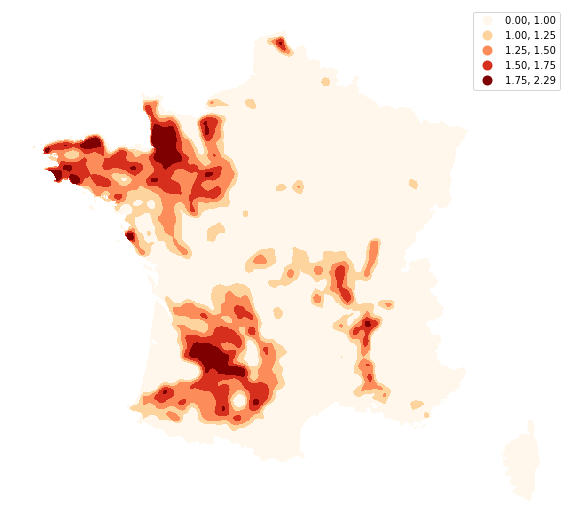

In [72]:
bins = [1, 1.25, 1.5, 1.75]
ax = scale_function.plot('c1',
                         #scheme = 'quantiles',
                         scheme = 'User_Defined',
                         classification_kwds={'bins':bins}, 
                         figsize=(10,10), legend=True, 
                         cmap='OrRd')
ax.axis(False)

In [ ]:
382354.71 6902663.09

In [96]:
bocage = df[(df.x >= 3500000 ) & (df.x <= (3500000 + 48000)) & (df.y>= 2920000) & (df.y<= (2920000+48000)) ]

In [82]:
bocage.y.max() - bocage.y.min()

48000

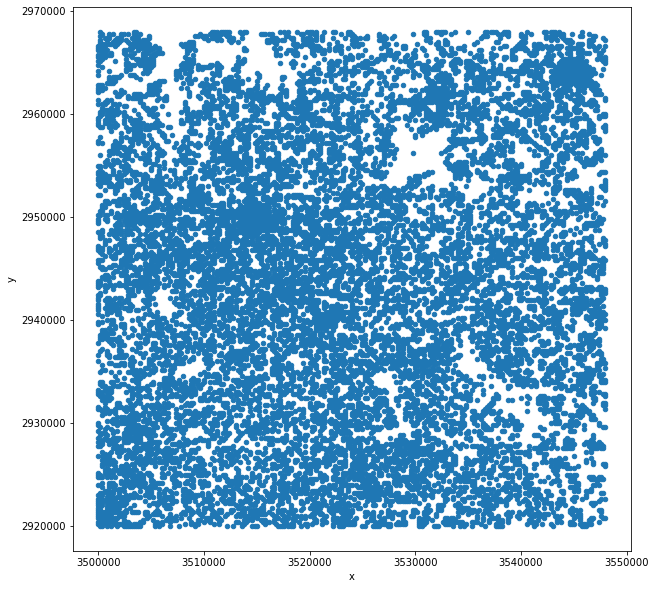

In [167]:
bocage.plot.scatter('x', 'y', figsize=(10,10))

In [159]:
size = np.array([800, 1600, 3200, 6400])

In [265]:
def mf(M, size):
    df = M.copy()
    df.Ind = df.Ind / df.Ind.sum()
    D0q = []
    c1q = []
    c2q = []
    D1q = []
    D2q = []
    for s in size:
        df.x = np.floor(df.x/s) * s
        df.y = np.floor(df.y/s) * s
        df = df.groupby(['x', 'y'], as_index=False)['Ind'].sum()
        D0q.append(-np.log(df.shape[0]))
        c1q.append(np.log(df.Ind).mean())
        c2q.append(np.log(df.Ind).var())
        D1q.append((np.log(df.Ind) *df.Ind).sum())
        D2q.append(np.log((df.Ind**2).sum()))
    return(np.array(D0q), np.array(c1q), np.array(c2q), np.array(D1q), np.array(D2q))

In [140]:
toto = mf(bocage, size)

In [154]:
np.sum(toto[0] * reg)

-7.447299208103339

In [155]:
toto[0]

array([8.14235428, 6.85329909, 5.54517744, 4.27666612])

In [138]:
totoa.append(4)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [119]:
a.append(2)

In [162]:
reg =(np.log(size)- np.mean(np.log(size)))  / np.var(np.log(size))

In [151]:
reg

array([-1.73123405, -0.57707802,  0.57707802,  1.73123405])

In [156]:
from scipy import stats

In [186]:
toto = mf(bocage, size)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),-toto[0])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),toto[1])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),toto[2])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),-toto[3])
print(slope)

1.8618248020258346
2.114861791273045
-0.2881623034621858
1.4878493083499014


In [165]:
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),toto[1])
slope

2.114861791273045

In [166]:
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),toto[2])
slope

-0.2881623034621858

In [ ]:
3888000.30 2914000

In [201]:
openfield = df[(df.x >= 3888000 ) & (df.x <= (3888000 + 48000)) & (df.y>= 2914000) & (df.y<= (2914000+48000)) ]
toto = mf(openfield, size)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),-toto[0])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),toto[1])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),toto[2])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),-toto[3])
print(slope)

1.2204119640437663
1.4756621527608462
-0.34508466133486304
1.022839566463037


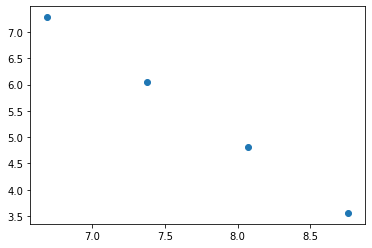

In [249]:
plt.scatter(np.log(size),  toto[3])

In [204]:
x,y =3754000, 2894000 #paris
area = df[(df.x >= x ) & (df.x <= (x + 48000)) & (df.y>= y) & (df.y<= (y+48000)) ]
toto = mf(area, size)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),-toto[0])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),toto[1])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),toto[2])
print(slope)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(size),-toto[3])
print(slope)

1.6271478668007564
1.9482516283497013
-1.5969089942737424
1.639730191061735


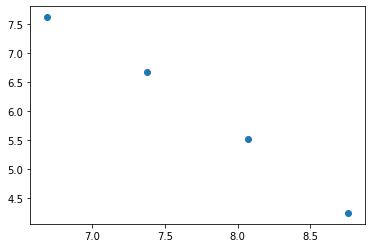

In [200]:
plt.scatter(np.log(size),  toto[0])

In [198]:
import matplotlib.pyplot as plt

In [369]:
esp = 24000
centre =  df.copy()
centre['x'] = np.floor(centre['x'] / esp) * esp + esp/2
centre['y'] = np.floor(centre['y'] /  esp) * esp + esp/2
centre = centre.groupby(['x', 'y'], as_index=False)['Ind'].sum()

In [370]:
centre['D0'] = np.NAN
centre['c1'] = np.NAN
centre['c2'] = np.NAN
centre['D1'] = np.NAN
centre['D2'] = np.NAN

In [371]:
side = 12000
for index, row in centre.iterrows():
    if (index % 1000)==0:
        print(index)
    area = df[(df.x >= row['x'] -side ) & (df.x <= (row['x'] + side)) & (df.y>= row['y'] - side) & (df.y<= (row['y']+side)) ]
    temp = mf(area, size)
    D0, _, _, _, _ = stats.linregress(np.log(size),temp[0])
    centre.D0[index] = D0
    c1, _, _, _, _ = stats.linregress(np.log(size),temp[1])
    centre.c1[index] = c1
    c2, _, _, _, _ = stats.linregress(np.log(size),temp[2])
    centre.c2[index] = c2
    D1, _, _, _, _ = stats.linregress(np.log(size),temp[3])
    centre.D1[index] = D1
    D2, _, _, _, _ = stats.linregress(np.log(size),temp[4])
    centre.D2[index] = D2
    

0
1000


In [372]:
temp = btbpy.dfToGrid(centre, '2154', 24000, False)

(3136800.0, 4351200.0, 1959600.0, 3200400.0)

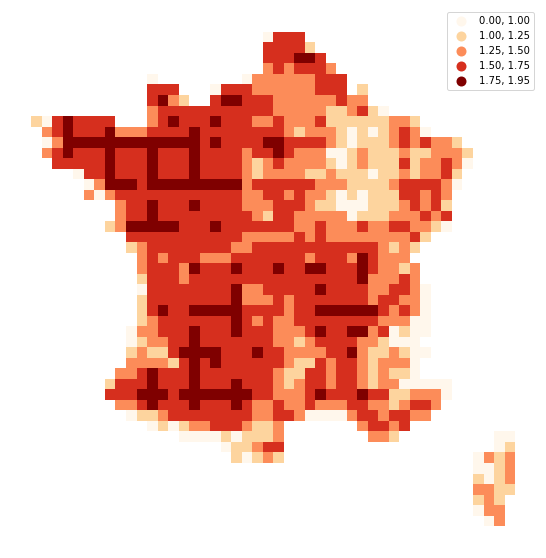

In [378]:
bins = [1, 1.25, 1.5, 1.75]
ax=temp.plot('D0',
          #scheme = 'quantiles',
          scheme = 'User_Defined',
          classification_kwds={'bins':bins}, 
          figsize=(10,10), legend=True, 
          cmap='OrRd')
ax.axis(False)

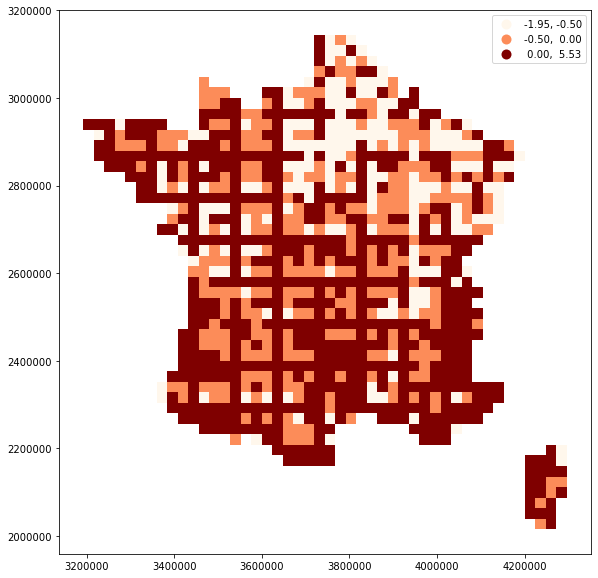

In [339]:
bins = [-0.5, 0]
ax=temp.plot('c2',
          #scheme = 'quantiles',
          scheme = 'User_Defined',
          classification_kwds={'bins':bins}, 
          figsize=(10,10), legend=True, 
          cmap='OrRd')
#ax.axis(False)

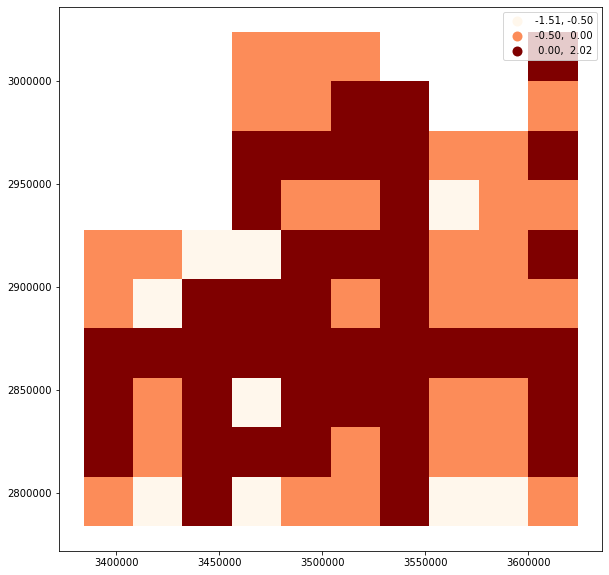

In [340]:
bins = [-0.5, 0]
ax=temp.cx[3400000:3600000,2800000:3000000 ].plot('c2',
          #scheme = 'quantiles',
          scheme = 'User_Defined',
          classification_kwds={'bins':bins}, 
          figsize=(10,10), legend=True, 
          cmap='OrRd')
#ax.axis(False)

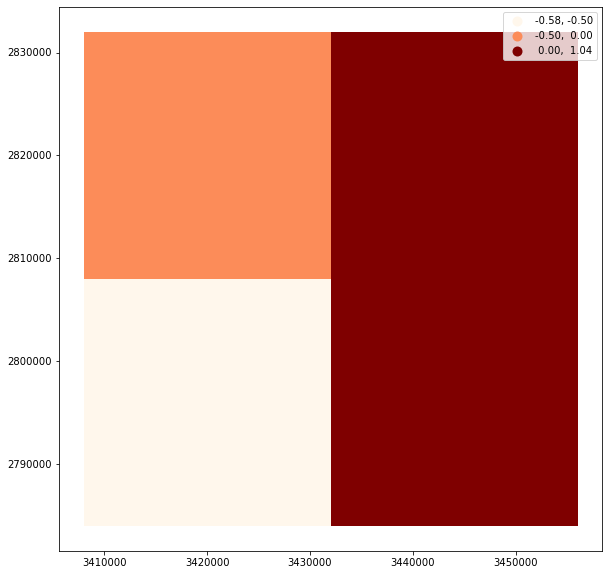

In [342]:
ax=temp.cx[3420000:3440000,2800000:2820000 ].plot('c2',
          #scheme = 'quantiles',
          scheme = 'User_Defined',
          classification_kwds={'bins':bins}, 
          figsize=(10,10), legend=True, 
          cmap='OrRd')
#ax.axis(False)

In [352]:
temp.cx[3420000:3440000,2800000:2820000 ]

,x,y,Ind,D0,c1,c2,D1,D2,geometry
77,3420000.0,2796000.0,47770.0,1.785206,2.084991,-0.576150,1.491421,1.261704,"POLYGON ((3408000.000 2808000.000, 3432000.000..."
78,3420000.0,2820000.0,32451.5,1.695858,1.866712,-0.085056,1.451637,1.203179,"POLYGON ((3408000.000 2832000.000, 3432000.000..."
105,3444000.0,2796000.0,28005.5,1.743225,1.907201,0.371888,1.408373,1.122839,"POLYGON ((3432000.000 2808000.000, 3456000.000..."
106,3444000.0,2820000.0,47009.0,1.693232,1.652876,1.037848,1.445886,1.124362,"POLYGON ((3432000.000 2832000.000, 3456000.000..."


In [636]:
side

24000

In [621]:
x,y =3444000.0 ,2820000.0 #bocage

In [608]:
x,y = 3888000-54000, 2914000-54000 #openfield

In [637]:
x,y = 3761000, 2889800

In [670]:
area = df[(df.x >= x-side ) & (df.x <= (x + side)) & (df.y>= y- side) & (df.y<= (y+side)) ]

In [686]:
def entropy(df, q):
    if q==1:
        return((np.log2(df.Ind) *df.Ind).sum())
    else:
        return(-np.log2((df.Ind**q).sum())/(1-q))

def mf(M, size, qs):
    df = M.copy()
    df.Ind = df.Ind / df.Ind.sum()
    
    Dq = np.zeros((size.size, qs.size))
    
    for i,s in enumerate(size):
        df.x = np.floor(df.x/s) * s
        df.y = np.floor(df.y/s) * s
        df = df.groupby(['x', 'y'], as_index=False)['Ind'].sum()
        for j,q in enumerate(qs):
            Dq[i,j] = entropy(df,q)
    Dq = pd.DataFrame(Dq)
    Dq.columns = qs
    return(Dq)
Beta = (np.log2(size) - np.log2(size).mean())/ np.log2(size).var() /4

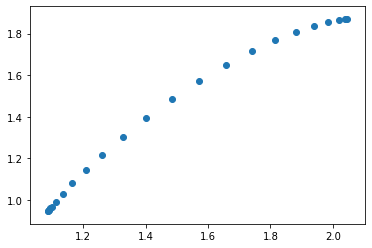

In [710]:
x,y = 3504600, 2935400#bocage
x,y = 3524600, 2917600#vire
area = df[(df.x >= x-side ) & (df.x <= (x + side)) & (df.y>= y- side) & (df.y<= (y+side)) ]
q = np.arange(0, 2.5,0.1)
toto = mf(area, size, q)
Dq = toto.mul(Beta, axis=0).sum().values
Tq = Dq * (q-1)
alpha_b = (Tq[1:] - Tq[:(Tq.size-1)])/0.1
falpha_b = alpha_b * q[:(q.size-1)] - (q[:(q.size-1)]-1) * Dq[:(q.size-1)]
plt.scatter(alpha_b, falpha_b)

138186.0

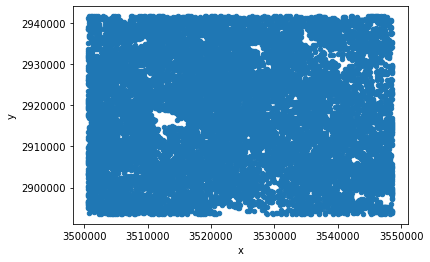

In [711]:
area.plot.scatter('x', 'y')
area.Ind.sum()

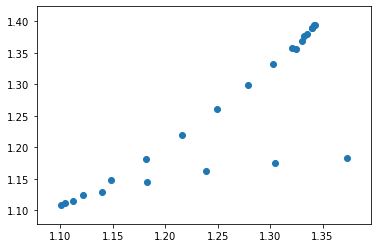

In [704]:
x,y = 3908800, 2887400 #openfield
area = df[(df.x >= x-side ) & (df.x <= (x + side)) & (df.y>= y- side) & (df.y<= (y+side)) ]
q = np.arange(0, 2.5,0.1)
toto = mf(area, size, q)
Dq = toto.mul(Beta, axis=0).sum().values
Tq = Dq * (q-1)
alpha_o = (Tq[1:] - Tq[:(Tq.size-1)])/0.1
falpha_o = alpha_o * q[:(q.size-1)] - (q[:(q.size-1)]-1) * Dq[:(q.size-1)]
plt.scatter(alpha_o, falpha_o)


117988.5

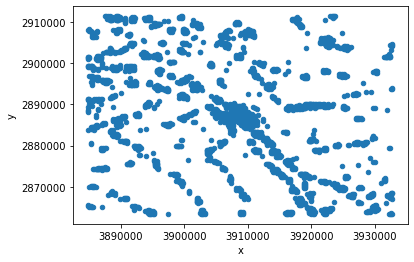

In [707]:
area.plot.scatter('x', 'y')
area.Ind.sum()

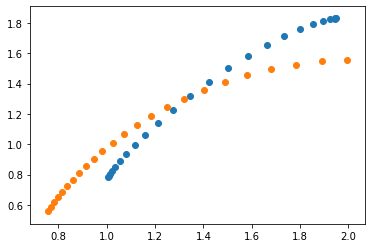

In [703]:
plt.scatter(alpha_b, falpha_b)
plt.scatter(alpha_o, falpha_o)


In [677]:
falpha = alpha * q[:(q.size-1)] - (q[:(q.size-1)]-1) * Dq[:(q.size-1)]

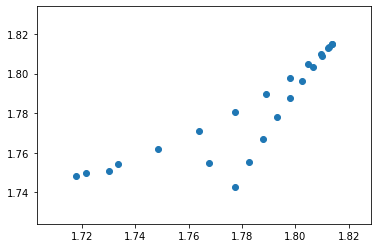

In [678]:
plt.scatter(alpha, falpha)

In [679]:
from sklearn.neighbors import KDTree
def neighbors_near_point(M, weight, list_of_radius):
    df = M.copy()
    neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
    for i, r in enumerate(list_of_radius):
        tree = KDTree(df[['x', 'y']]) 
        neigh = RadiusNeighborsRegressor(radius=r)
        neigh.fit(df[['x', 'y']],  df.Ind)
        neighbors[:,i] = tree.query_radius(df[['x', 'y']], r= r, count_only=True) * neigh.predict(df[['x', 'y']])
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    return(result)

neighbors = neighbors_near_point(df, 'Ind', list_of_radius)

In [680]:
list_of_radius = np.array([400, 800, 1600, 3200])
neighbors = neighbors_near_point(area, 'Ind', list_of_radius)

In [681]:
def entropy(P, q):
    if q==1:
        return((np.log2(P)).mean())
    else:
        return(-np.log2((P**(q-1)).mean())/(1-q))

def mf(M, size, qs):
    df = M.copy()   
    Dq = np.zeros((size.size, qs.size))
    
    for i,s in enumerate(size):
        for j,q in enumerate(qs):
            Dq[i,j] = entropy(df[str(s)],q)
    Dq = pd.DataFrame(Dq)
    Dq.columns = qs
    return(Dq)
Beta = (np.log2(size) - np.log2(size).mean())/ np.log2(size).var() /4

In [682]:
toto2 = mf(neighbors, list_of_radius,  q)
Beta = (np.log2(list_of_radius) - np.log2(list_of_radius).mean())/ np.log2(list_of_radius).var() /4

In [683]:
Dq = toto2.mul(Beta, axis=0).sum().values
Tq = Dq * (q-1)
alpha = (Tq[1:] - Tq[:(Tq.size-1)])/0.1
falpha = alpha * q[:(q.size-1)] - (q[:(q.size-1)]-1) * Dq[:(q.size-1)]

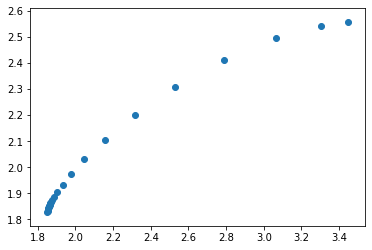

In [684]:
plt.scatter(alpha, falpha)

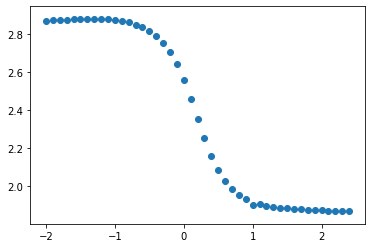

In [653]:
plt.scatter(q, Dq)

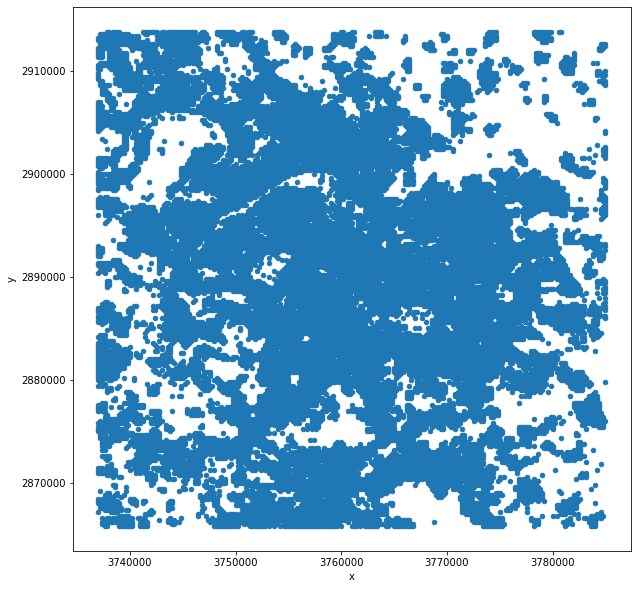

In [640]:
area.plot.scatter('x', 'y', figsize=(10,10))

In [639]:
area.Ind.sum()

9592991.0

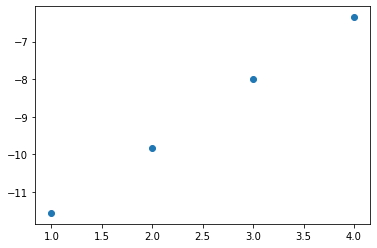

In [666]:
plt.scatter([1,2,3,4],toto.iloc[:,20])